#  NLP-lab :  Word embeddings

In this series of exercises, we will explore three word embeddings:

* [Collobert & Weston](http://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf) https://ronan.collobert.com/senna/
* [Word2Vec](https://arxiv.org/abs/1301.3781)
* [BERT](https://huggingface.co/bert-base-uncased) 


In the code already provided, add your code to the place indicated by `YOUR CODE HERE`.

**Important** : do NOT commit the data and embedding files in your repository git : it is a waste of resources and it takes more time to clone.
> Use https://docs.github.com/en/get-started/getting-started-with-git/ignoring-files


In [1]:
# basic imports
import os
import matplotlib.pyplot as plt
# display matplotlib graphics in notebook
%matplotlib inline 
import seaborn as sns

# disable warnings for libraries
import warnings
warnings.filterwarnings("ignore")

# configure logger
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)


###  Embeddings exploration with Collobert's embeddings

Upload the files containing the embeddings to `data`:
* Collobert (size 50): [collobert_embeddings.txt.zip](https://storage.teklia.com/shared/deepnlp-labs/collobert_embeddings.txt.zip) which contains the embedding vectors and [collobert_words.lst](https://storage.teklia.com/shared/deepnlp-labs/collobert_words.lst) which contains the associated words;

You need to unzip the files to load them.

Feel free to open the files to see what they contain (it's sometimes surprising).

#### Question: 
>* Add the files to your .gitignore
>* Give the size in Mb of the embeddings files before unzipping.
>* By exploring the content of the embedding files, give the number of words for which these files provide embeddings.



> on Windows: (Get-Item collobert_embeddings.txt.zip).length / 1MB 

* Reminder: 1 megabytes = 1,048,576 bytes
$$
\text{Size in MB} = \frac{\text{Size in bytes}}{1 \text{ MB}}
$$


The unzipped embeddings file is about 23.71 MB.

> on Windows: (Get-Content collobert_words.lst).Count 

* The file 'collobert_embeddings.txt' contains 130000 words.
* The file 'collobert_words.lst' also includes 130000 words.

### List of closest words

The aim of this exercise is to list the closest words to a given word for the Collobert embedding. First, we'll load the vectors of the Collobert embedding into a numpy array and the associated words into a python list. Then we'll use the [scipy KDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) data structure to quickly search for the vectors closest to a series of words.


#### Question: 
>* load embedding vectors from the file `data/collobert_embeddings.txt` using the numpy function [genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html)
>* load the words associated with the vectors from the `data/collobert_words.lst` file into a python list (using `open()` and `readlines()`)
>* check that the sizes are correct


In [2]:
import numpy as np
# YOUR CODE HERE

# embeddings
embeddings = np.genfromtxt("data/collobert_embeddings.txt")

# words
with open("data/collobert_words.lst", "r", encoding="utf-8") as file:
    words = [line.strip() for line in file.readlines()]

# checking sizes
assert embeddings.shape[0] == len(words), "Error : The number of vectors does not correspond to the number of words."

print(f"Number of words : {len(words)}")
print(f"Shape of embeddings : {embeddings.shape}")

Number of words : 130000
Shape of embeddings : (130000, 50)


KD trees are a very efficient data structure for storing large sets of points in a multi-dimensional space and performing very efficient nearest-neighbour searches. 

#### Question 
> * Initialise the [KDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) structure with Collobert's embedding vectors.
> * Using the [tree.query](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html#scipy.spatial.KDTree.query) function, display the 5 nearest words for the following words: ‘mother’, ‘computer’, ‘dentist’, ‘war’, ‘president’, ‘secretary’, ‘nurse’.  *Hint: you can use the function `collobert_words.index(w)` to obtain the index of a word in the list of words*.
> * Create a `words_plus_neighbors` list containing the words and all their neighbours (for the next question)

In [3]:
from scipy import spatial
# YOUR CODE HERE

# initialisation
tree = spatial.KDTree(embeddings)

targets = ["mother", "computer", "dentist", "war", "president", "secretary", "nurse"]

words_plus_neighbors = []

for word in targets:
    if word in words:
        index = words.index(word)
        distances, indices = tree.query(embeddings[index], k=6) 
        neighbors = [words[i] for i in indices if i != index] 
        print(f"{word}: {neighbors}")
        words_plus_neighbors.append((word, neighbors))
    else:
        print(f"Word '{word}' not found.")

print("\nComplete list :")
print(words_plus_neighbors)

mother: ['daughter', 'wife', 'father', 'husband', 'son']
computer: ['laptop', 'multimedia', 'desktop', 'software', 'wiki']
dentist: ['pharmacist', 'midwife', 'physician', 'housekeeper', 'veterinarian']
war: ['revolution', 'death', 'court', 'independence', 'history']
president: ['governor', 'chairman', 'mayor', 'secretary', 'senator']
secretary: ['minister', 'treasurer', 'chairman', 'commissioner', 'undersecretary']
nurse: ['physician', 'veterinarian', 'dentist', 'surgeon', 'midwife']

Complete list :
[('mother', ['daughter', 'wife', 'father', 'husband', 'son']), ('computer', ['laptop', 'multimedia', 'desktop', 'software', 'wiki']), ('dentist', ['pharmacist', 'midwife', 'physician', 'housekeeper', 'veterinarian']), ('war', ['revolution', 'death', 'court', 'independence', 'history']), ('president', ['governor', 'chairman', 'mayor', 'secretary', 'senator']), ('secretary', ['minister', 'treasurer', 'chairman', 'commissioner', 'undersecretary']), ('nurse', ['physician', 'veterinarian', 'den

### Visualisation with T-SNE

Embeddings are vectors with several hundred dimensions. It is therefore not possible to display them in their original space. However, it is possible to apply dimension reduction algorithms to display them in 2 or 3 dimensions. One of the dimension reduction algorithms allowing 2D visualisation is [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). 

#### Question
> * Create a `word_vectors` object of type `np.array` from a list containing all the embeddings of the words in the `words_plus_neighbors` list.
> * Create a tSNE object from the `from sklearn.manifold import TSNE` library with the parameters `random_state=0`, `n_iter=2000` and `perplexity=15.0` for a 2-dimensional view.
> * Calculate *T* the tSNE transformation of the `word_vectors` by applying function `.fit_transform(word_vectors)` to the tSNE object. This function estimates the parameters of the tSNE transformation and returns the reduced-dimension representation of the vectors used for estimation.
> * Use the `scatterplot` function from [seaborn](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) to represent points in 2 dimensions and add word labels using the `plt.annotate` function.

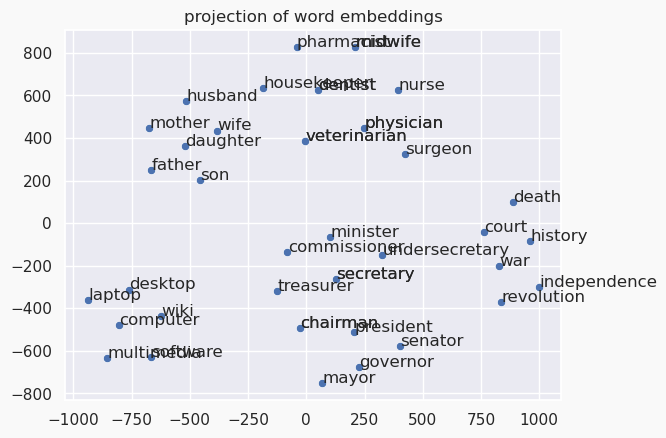

In [4]:
from sklearn.manifold import TSNE
# graphics
import matplotlib.pyplot as plt
# display matplotlib graphics in notebook
%matplotlib inline 
import seaborn as sns

# retrieve the word representation
# YOUR CODE HERE
word_vectors = np.array([embeddings[words.index(word)] for word, neighbors in words_plus_neighbors for word in [word] + neighbors])

# create the tSNE transform
# YOUR CODE HERE
tsne = TSNE(n_components=2, random_state=0, n_iter=2000, perplexity=15.0)

# fit and transform the word vectors, store in T
# YOUR CODE HERE
T = tsne.fit_transform(word_vectors)

# plot
fig = plt.figure()
fig.patch.set_facecolor('#f9f9f9')

sns.set(rc={'figure.figsize':(14, 8)})
sns.set(font_scale=1)

sns.scatterplot(x=T[:, 0], y=T[:, 1])

word_list = [word for word, neighbors in words_plus_neighbors for word in [word] + neighbors]
for label, x, y in zip(word_list, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

plt.title("projection of word embeddings")
plt.show()

### Semantic arithmetic with Word2Vec

One of the most original properties of Word2Vec embeddings is that the semantic relationships between vectors can be modelled by arithmetic operations. Given vectors representing the words `king`, `man` and `woman`, it is possible to compute the vector `v` as :  

`v = vector(king)-vector(man)+vector(woman)`

This operation corresponds to the following semantic relationship: *The king is to the man what the queen is to the woman*, which translates into the following arithmetic: *the concept of king, minus the concept of man plus the concept of woman gives the concept of queen*.

In fact, if we look in the embedding for the word whose closest vector is `v`, we find `reine`.


We will use a Word2Vec model pre-trained on the French Wac corpus.  This model has been trained on a corpus of 1 billion French words. 

This embedding is available in 2 formats:
- a text format for easy exploration of the model :
    - frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.txt](https://storage.teklia.com/shared/deepnlp-labs/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.txt)
- a binary format that can be loaded using the Gensim library: 
    - [enWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin](https://storage.teklia.com/shared/deepnlp-labs/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin)

Download the text file onto your machine to analyse it.

#### Question: 
>* Add the file to your .gitignore
>* Give the size in Mb of the embedding files
>* By exploring the contents of the embedding file in text format, give the number of words for which this model provides embeddings and the size of the embedding for each word.



* The file is about 120.21 MB.

In [ ]:
from gensim.models import KeyedVectors

embedding_file ="data/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"
model = KeyedVectors.load_word2vec_format(embeddings_path, binary=True)

num_words = len(model.index_to_key) 
embedding_size = model.vector_size   

print(f"Number of words : {num_words}")
print(f"Embeddings size : {embedding_size} dimensions")

03:09:46 INFO:loading projection weights from data/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin
03:09:46 INFO:KeyedVectors lifecycle event {'msg': 'loaded (155562, 200) matrix of type float32 from data/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-02-25T15:09:46.999512', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 16:05:46) [GCC 13.3.0]', 'platform': 'Linux-6.1.0-30-amd64-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


Number of words : 155562
Embeddings size : 200 dimensions


#### Word similarity

We are now going to use the [Gensim] library (https://radimrehurek.com/gensim/) to load the Word2Vec model and use it. 

#### Question: 
>* Modify the following code to load the Word2Vec template file in binary format using [load_word2vec](https://radimrehurek.com/gensim/models/keyedvectors.html#how-to-obtain-word-vectors)
>* Choose a couple of words and find the closest words according to the model using [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)
>* To guess the meaning of the words ‘yokohama’, ‘kanto’ and ‘shamisen’, look for their nearest neighbours. Explain the results.


In [6]:
from gensim.models import KeyedVectors

## YOUR CODE HERE
embedding_file ="data/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"
model = KeyedVectors.load_word2vec_format(embedding_file, binary=True, unicode_errors="ignore")
## YOUR CODE HERE
model.most_similar("chevalier")

02:55:12 INFO:loading projection weights from data/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin
02:55:13 INFO:KeyedVectors lifecycle event {'msg': 'loaded (155562, 200) matrix of type float32 from data/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-02-25T14:55:13.581839', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 16:05:46) [GCC 13.3.0]', 'platform': 'Linux-6.1.0-30-amd64-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


[('commandeur', 0.6844523549079895),
 ('chevaliers', 0.6799763441085815),
 ('écuyer', 0.6333731412887573),
 ('grand-croix', 0.621898353099823),
 ('preux', 0.6011075377464294),
 ('chevalerie', 0.5404021143913269),
 ('légion', 0.5335969924926758),
 ('honneur', 0.4953608810901642),
 ('yvain', 0.4855087101459503),
 ('insignes', 0.4742659330368042)]

#### Semantic arithmetic

One of the most original properties of Word2Vec embeddings is that the semantic relationships between vectors can be modelled by arithmetic operations. Given vectors representing the words `king`, `man` and `woman`, it is possible to compute the vector `v` as :  

`v = vector(king)-vector(man)+vector(woman)`

This operation corresponds to the following semantic relationship: *The king is to the man what the queen is to the woman*, which translates into the following arithmetic: *the concept of king, minus the concept of man plus the concept of woman gives the concept of queen*.

In fact, if we look in the embedding for the word whose closest vector is `v`, we find `reine`.

#### Question: 
>* using the function [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar) specifying the arguments `positive` for the vectors to be added and `negative` for the vectors to be subtracted, check the relationship *the concept of king, minus the concept of man plus the concept of woman gives the concept of queen*.
>* Using the same method, find XXX in the following semantic relations
>   * Paris is to France what XXX is to Japan.
>   * Chevalier is to France what XXX is to Japan.

In [7]:
model.most_similar(positive=["roi","femme"], negative=["homme"], topn=1)

[('reine', 0.6945513486862183)]

In [8]:
model.most_similar(positive=["paris","japon"], negative=["france"],topn=1)

[('tokyo', 0.6542136073112488)]

In [9]:
model.most_similar(positive=["chevalier","japon"], negative=["france"], topn=1)

[('samouraï', 0.5616667866706848)]

## Contextual embeddings with BERT 

BERT was one of the first freely available Transformer language models, trained on large corpora. Many other models are available on HuggingFace.

As BERT is a contextual model, it is necessary to have it predict whole sentences in order to study the word embeddings it produces. In this section, we will compare the embeddings obtained for polysemous words according to the sentence in which they are used.

In English, *plant* has two meanings: plant and vegetable. With a non-contextual embedding, such as Glove or Colobert, these two meanings of the word plus are associated with an identical embedding. With BERT, we'll see that the same word can have several embeddings depending on the context.

First, load the BERT model and tokenizer from HuggingFace : 

In [19]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model 
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # to access the hidden states
                                  )

# set the model to "evaluation" mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Tokenizer

Language models are trained with a specific breakdown of sentences into tokens. These tokens can be words or parts of words. It is necessary to use the tokenizer corresponding to each model.

tokenizer.vocab.keys() gives the list of all the tokens known for the language model. 

#### Question
>* How many different tokens are known to the BERT tokenizer?
>* Display a hundred tokens at random. What do you find?

In [20]:
import random
# number of token in tokenizer
print(f"Number of different tokens in BERT : {len(tokenizer.vocab.keys())}")

# sample of 100 tokens
random.sample(list(tokenizer.vocab.keys()), 100)

Number of different tokens in BERT : 30522


['##sos',
 'intrigued',
 'landfall',
 'programmers',
 'marsden',
 '##ulation',
 'curtains',
 '[unused17]',
 '##rber',
 'butler',
 '##：',
 'town',
 'borrow',
 'geographic',
 '##iti',
 '##ъ',
 '##llo',
 '##in',
 'tsar',
 'anticipated',
 'morphology',
 'identity',
 'hartley',
 'contest',
 '##hur',
 '##rent',
 'merging',
 'awarding',
 'attraction',
 'exquisite',
 'oversight',
 '##rio',
 'dylan',
 'spies',
 '##ович',
 'curvature',
 'sudan',
 'ニ',
 'כ',
 'tired',
 'touch',
 '勝',
 'guarantees',
 '1802',
 '##ence',
 'mathias',
 '人',
 '##itated',
 '##щ',
 '##tania',
 'manifold',
 'noah',
 'porter',
 '1878',
 'roll',
 'tier',
 '##osta',
 'scan',
 'spine',
 'affiliate',
 'mp',
 'candidate',
 'zero',
 'potomac',
 'gingerly',
 'pig',
 'cohen',
 'streaks',
 'baby',
 'pictorial',
 'pretended',
 '##lassified',
 '##ি',
 '##zel',
 'asserting',
 'aquarium',
 '##bar',
 'ding',
 '##ang',
 '##tagram',
 'temperature',
 'spectator',
 '°',
 'ʼ',
 'es',
 'mets',
 'hilly',
 'shelter',
 '##pling',
 'preferred',
 

The tokenizer splits sentences and transforms the elements (words or sub-words) into clues. 

BERT can process several sentences, but you need to tell it how the sentences (segments) have been split, with an index: 0 for the first sentence, 1 for the second. 

Two specific tokens must also be added: 
* CLS], a specific token used for sentence classification
* SEP], the end of sentence token.

#### Question
>* Apply the bert_tokenize function to the 3 phases and keep the 3 vectors (index, token, segment).
>* Display this information for each of the sentences and check that the word *plant* has the same token index in the two sentences in which it appears.

In [30]:
snt1 = "The plant has reached its maximal level of production."
snt2 = "The cars are assembled inside the factory."
snt3 = "A plant needs sunlight and water to grow well."


def bert_tokenize(snt):
    """ Apply the BERT tokenizer to a list of words representing a sentence
        and return 3 lists: 
        - list of token indx
        - list of token for debugging, not used by the BERT model
        - list of sentence index
        """
    # Add the special tokens.
    tagged_snt = "[CLS] " + snt + " [SEP]" 
    # Tokenize
    tokenized_snt = tokenizer.tokenize(tagged_snt)
    # convert tokens to indices
    indexed_snt = tokenizer.convert_tokens_to_ids(tokenized_snt)
    # mark the words in sentence.
    segments_ids = [1] * len(tokenized_snt)

    return (indexed_snt, tokenized_snt, segments_ids)

# YOUR CODE HERE
sentences = [snt1, snt2, snt3]

for i, snt in enumerate(sentences, start=1):
    indexed_snt, tokenized_snt, segments_snt = bert_tokenize(snt)

    for index, token, segment in zip(indexed_snt, tokenized_snt, segments_snt):
        print(f"S{i} - Index: {index}, Token: {token}, Segment: {segment}")

    print("\n" + "="*70 + "\n")

plant_index_snt1 = tokenized_snt1.index("plant") if "plant" in tokenized_snt1 else None
plant_index_snt3 = tokenized_snt3.index("plant") if "plant" in tokenized_snt3 else None

print("\n'plant' index :")
print(f"Index in sentence 1 : {plant_index_snt1}, Token index : {indexed_snt1[plant_index_snt1]}")
print(f"Index in sentence 3 : {plant_index_snt3}, Token index : {indexed_snt3[plant_index_snt3]}")
print(f"Same token index ? {'Yes' if indexed_snt1[plant_index_snt1] == indexed_snt3[plant_index_snt3] else 'No'}")

S1 - Index: 101, Token: [CLS], Segment: 1
S1 - Index: 1996, Token: the, Segment: 1
S1 - Index: 3269, Token: plant, Segment: 1
S1 - Index: 2038, Token: has, Segment: 1
S1 - Index: 2584, Token: reached, Segment: 1
S1 - Index: 2049, Token: its, Segment: 1
S1 - Index: 29160, Token: maximal, Segment: 1
S1 - Index: 2504, Token: level, Segment: 1
S1 - Index: 1997, Token: of, Segment: 1
S1 - Index: 2537, Token: production, Segment: 1
S1 - Index: 1012, Token: ., Segment: 1
S1 - Index: 102, Token: [SEP], Segment: 1


S2 - Index: 101, Token: [CLS], Segment: 1
S2 - Index: 1996, Token: the, Segment: 1
S2 - Index: 3765, Token: cars, Segment: 1
S2 - Index: 2024, Token: are, Segment: 1
S2 - Index: 9240, Token: assembled, Segment: 1
S2 - Index: 2503, Token: inside, Segment: 1
S2 - Index: 1996, Token: the, Segment: 1
S2 - Index: 4713, Token: factory, Segment: 1
S2 - Index: 1012, Token: ., Segment: 1
S2 - Index: 102, Token: [SEP], Segment: 1


S3 - Index: 101, Token: [CLS], Segment: 1
S3 - Index: 1037, T

## Inference

To calculate embeddings, we need to make a prediction using the BERT model on a complete sentence. The *predict_hidden* function converts the token and segment index lists into a pytorch tensor and applies the model. 

The model used is a 12-layer model. We will use the last hidden layer of the model as an embedding to represent the words. Other solutions are possible, such as concatenation or averaging of several layers.


#### Question
>* Apply the model to each of the 3 sentences and store the resulting embeddings (tensors).
>* Display the dimension of the resulting tensors. What is the dimension of the embedding vector for each word?

In [41]:
def predict_hidden(indexed_snt, segments_ids):
    """Apply the BERT model to the input token indices and segment indices
        and return the last hidden layer
    """
    with torch.no_grad():
        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_snt])
        segments_tensors = torch.tensor([segments_ids])
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
        one_hidden_layer = hidden_states[12][0]
        
    return one_hidden_layer

# YOUR CODE HERE
hidden_layer_snt1 = predict_hidden(indexed_snt1, segments_snt1)
hidden_layer_snt2 = predict_hidden(indexed_snt2, segments_snt2)
hidden_layer_snt3 = predict_hidden(indexed_snt3, segments_snt3)

print(f"Dimension of last hidden layer in sentence 1: {hidden_layer_snt1.shape}")
print(f"Dimension of last hidden layer in sentence 2: {hidden_layer_snt2.shape}")
print(f"Dimension of last hidden layer in sentence 3: {hidden_layer_snt3.shape}")
print(f"\nDimension of embeddings for each word: {hidden_layer_snt1.shape[1]}")


Dimension of last hidden layer in sentence 1: torch.Size([12, 768])
Dimension of last hidden layer in sentence 2: torch.Size([10, 768])
Dimension of last hidden layer in sentence 3: torch.Size([12, 768])

Dimension of embeddings for each word: 768


The hidden layer returned by the *predict_hidden* function is a tensor containing a context vector representing each token in the input sentence. We can use this vector to represent the meaning of this word as a function of its context. We're going to compare the representation of the polysemous word *plant* as a function of its context.

#### Question
>* Using the [cosine distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html), calculate the following distances:
> * distance between *plant* in sentence 1 (plant-factory) and *plant* in sentence 3 (plant-vegetal)
> * distance between *plant* in sentence 1 (plant-factory) and *factory* in sentence 2 (plant-vegetal) 
> * distance between *plant* in sentence 1 (plant-factory) and *production* in sentence 2 
> * distance between *plant* in sentence 3 (plant-vegetal) and *production* in sentence 2 
> * How can we interpret these distances?

In [52]:
from scipy.spatial.distance import cosine

# YOUR CODE HERE
def last_layer_token(hidden_layer, token_index):
    return hidden_layer[token_index]

factory_index_snt2 = tokenized_snt2.index("factory")
production_index_snt1 = tokenized_snt1.index("production")

plant_embedding_snt1 = last_layer_token(hidden_layer_snt1, plant_index_snt1)
plant_embedding_snt3 = last_layer_token(hidden_layer_snt3, plant_index_snt3)
factory_embedding_snt2 = last_layer_token(hidden_layer_snt2, factory_index_snt2)
production_embedding_snt1 = last_layer_token(hidden_layer_snt1, production_index_snt1)

dist_plant_snt1_snt3 = cosine(plant_embedding_snt1, plant_embedding_snt3)
dist_plant_factory_snt1_snt2 = cosine(plant_embedding_snt1, factory_embedding_snt2)
dist_plant_production_snt1 = cosine(plant_embedding_snt1, production_embedding_snt1)
dist_plant_production_snt3_snt1 = cosine(plant_embedding_snt3, production_embedding_snt1)

print(f"Cosine distance between 'plant' in sentence 1 and 'plant' in sentence 3: {dist_plant_snt1_snt3:.2f}")
print(f"Cosine distance between 'plant' in sentence 1 and 'factory' in sentence 2: {dist_plant_factory_snt1_snt2:.2f}")
print(f"Cosine distance between 'plant' in sentence 1 and 'production' in sentence 1: {dist_plant_production_snt1:.2f}")
print(f"Cosine distance between 'plant' in sentence 3 and 'production' in sentence 1: {dist_plant_production_snt3_snt1:.2f}")

Cosine distance between 'plant' in sentence 1 and 'plant' in sentence 3: 0.50
Cosine distance between 'plant' in sentence 1 and 'factory' in sentence 2: 0.31
Cosine distance between 'plant' in sentence 1 and 'production' in sentence 1: 0.24
Cosine distance between 'plant' in sentence 3 and 'production' in sentence 1: 0.62


* A distance of 0.50 suggests that both instances of "plant" are related but distinct, since they are the same word but have different meanings.

* A low cosine distance indicates that the two tokens are semantically similar in the context of the sentence. For example, "plant" in sentence 1 refers to a production facility, and "factory" in sentence 2 refers to a similar concept. A distance of 0.31 shows that these two terms are closely related. The same applies to "plant" and "production" in sentence 1 as well.

* On the other hand, a high cosine distance means that the tokens are more semantically different in the context of the sentence. For instance, the distance between "plant" in sentence 3 and "production" in sentence 1 is high (0.62), showing that "production" is quite different from the botanical "plant".